# Project 5: Image Reconstruction with Convolutional Autoencoders (Conv AEs)

Description:

Autoencoders (AEs) are a self-supervised approach to extracting useful compressed representation of data. They are being used in many different deep learning contexts and especially in Computer Vision for applications such as denosining and in general for transfer learning. A new divide of the AE’s, so-called variational AEs (VAEs), are nowadays considered a generative model next to GANs. The goal of this exercise is to use your learnings from the ML Course EE468 to:

1. Build a simple pipeline to load and preprocess your input images if needed, and train a convolutional AE (Conv AE) on Fashion MNIST (FMNIST) dataset. Use the links provided below to see samples of different convolutional architectures (encdoer and decoder) people have used before, but be innovative and use your learnings from the course to explore different architectures, and components, to hopefully land on the best architecture! Note: you don’t need to pick a huge encoder/decoder model.
2. As part of this exercise, visualize the reconstruction error/loss throughout the training, as well as a few samples of the reconstructed test images.
3. Make sure you pipeline saves the best model according to the loss value. You need to save the so-called “checkpoint” (ckpt) files. It never hurts to save the last model too!
4. You essentially don’t need the labels (self-supervised learning!) but use them for your visualizations to see if the reconstructed images match the labels.
5. Note: there are two schools of thought for the type of loss function you can use, i) cross-entropy loss, ii) mean squared error loss. The choice is yours unless you have to go for one, for instance, because of your data and preprocessing strategy. Explain which one you opted and why.
6. Repeat the same exercise for CIFAR10. Don’t forget that now you have 3 input channels. Do you find CIFAR10 a more difficult dataset to obtain a good reconstruction quality, or an easier one? Make your encoder/decoder architecture a bit more complex if need be, and explain your strategy.
7. Edit your model to also return the latent embedding besides the reconstructed image. Make sure your “bottleneck layer” is fully-connected (not convolutional) for this part. How did you choose the size (number of neurons) of this bottleneck layer?
8. Scatter plot these embeddings in two-dimensional (2D). Obviously, unless the size of the bottleneck layer is 2, 2D plots don’t make sense! How can you use a dimensionality reduction technique to get a 2D representation of these embeddings? What would be your choice? Consider PCA, tSNE! If you look for something even more interesting, study and employ unified manifold approximation (UMAP). They’re shown to be even better than tSNE. See the link below.
9. What happens if you plot these embeddings based on the associated labels in different colors? Will they be clustered according to the label? Feel free to add a simple clustering approach before using tSNE (or UMAP). Explain your understanding.
Dataset:

We will use the following datasets. They are both images of size 28 by 28 pixels. However, Fashion MNIST (FMNIST) is grayscale (1 input channel) while CIFAR10 is colored (3 input channels for Red, Green and Blue). FMNIST has 60,000 images for training and 10,000 for testing and CIFAR10 has 50,000 for training and 10,000 for testing. This is your choice to have a validation set split from the training set. Below you can find the link to the datasets, even though bear in mind that these datasets are super standard and both Pytorch and Keras/TF have dataloaders for immediately loading them.

Fashion MNIST (FMNIST): Labels 0-9 corresponds to the following categories:

0:tshirt 1:trouser, 2:pullover, 3:dress, 4:coat, 5:sandal, 6:shirt, 7:sneaker, 8:bag, 9:ankle boot

CIFAR10: Labels 0-9 corresponds to the following categories:

0:airplane, 1:automobile, 2:bird, 3:cat, 4:deer, 5:dog, 6:frog, 7:horse, 8:ship, 9:truck

For more information, code, and data, we refer you to:

https://www.kaggle.com/residentmario/autoencoders

https://www.cs.toronto.edu/~kriz/cifar.html

https://github.com/zalandoresearch/fashion-mnist

https://www.kaggle.com/robinteuwens/anomaly-detection-with-auto-encoders

https://umap-learn.readthedocs.io/en/latest/basic_usage.html

# CIFAR10

## Preprocessing

In [1]:

import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import matplotlib.pyplot as plt
import os

In [2]:
# @title reproducibility stuff
import random
torch.manual_seed(42)
np.random.seed(42)
random.seed(0)

torch.cuda.manual_seed(0)

torch.backends.cudnn.deterministic = True  # Note that this Deterministic mode can have a performance impact (reproducible)
torch.backends.cudnn.benchmark = False # find the optimal algorithm, but may lead to performance issues

In [3]:
# Define hyperparameters

Latent_dim = 128 # dim of latent space
batch_size = 128
learning_rate = 1e-3
use_gpu = True

device = torch.device("cuda:0" if use_gpu and torch.cuda.is_available() else "cpu")


# Data loading
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
from torchvision.datasets import CIFAR10
img_transform = transforms.Compose([
    transforms.ToTensor()
])
batch_size = 128
train_dataset = CIFAR10(root='./data/CIFAR10', download=True, train=True, transform=img_transform)
train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

test_dataset = CIFAR10(root='./data/CIFAR10', download=True, train=False, transform=img_transform)
test_dataloader = DataLoader(test_dataset, batch_size=max(10000, batch_size), shuffle=True)

Files already downloaded and verified
Files already downloaded and verified


## Dataset visualization

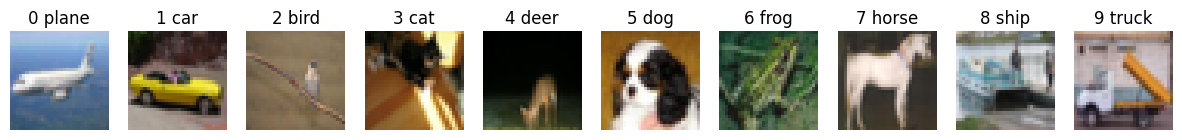

In [4]:
# Create an empty dictionary to store the first image of each category
CIFAR10_labels = ['plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']
category_images = {}

for images, labels in test_dataloader:
    for i in range(len(labels)):
        label = labels[i].item()  # convert tensor to integer
        # If the image of this category has not been stored yet
        if label not in category_images:
            img = images[i]
            # If the image is a Tensor, convert it to a NumPy array
            if isinstance(img, torch.Tensor):
                img = img.permute(1, 2, 0)  # Change (C, H, W) to (H, W, C)
                img = img.numpy()

            # Store the image
            category_images[label] = img

    # If we have collected images from all categories, break the loop
    if len(category_images) == 10:
        break

# Create a figure to display the images
fig = plt.figure(figsize=(15, 6))

# Sort the categories in increasing order
sorted_categories = dict(sorted(category_images.items()))

for label, img in sorted_categories.items():
    ax = fig.add_subplot(1, 10, label+1)
    ax.set_title(f'{label} '+CIFAR10_labels[label])
    ax.imshow(img)
    ax.axis('off')

plt.show()


## Autoencoders

### Conv AE for CIFAR10

In [5]:
class conv_Encoder(nn.Module):
    def __init__(self, latent_dim):
        super(conv_Encoder,self).__init__()
        self.network = nn.Sequential(
            nn.Conv2d(3, 12, 4, stride=2, padding=1),  # Output size: [batch, 12, 16, 16]
            nn.ReLU(),
            nn.Conv2d(12, 24, 4, stride=2, padding=1),  # Output size: [batch, 24, 8, 8]
            nn.ReLU(),
            nn.Conv2d(24, 48, 4, stride=2, padding=1),  # Output size: [batch, 48, 4, 4]
            nn.ReLU(),
            nn.Flatten(),  # Flatten to [batch, 48*4*4]
            nn.Linear(48*4*4, latent_dim),  # Map to latent space
        )


    def forward(self,x):
        x = x.view(-1,3,32,32)
        output = self.network(x)
        return output

class conv_Decoder(nn.Module):
    def __init__(self, latent_dim):
        super(conv_Decoder,self).__init__()
        self.linear = nn.Sequential(
            nn.Linear(latent_dim, 48*4*4),
            nn.ReLU()
        )

        self.network = nn.Sequential(
            nn.ConvTranspose2d(48, 24, 4,stride=2, padding=1), # [batch, 24, 8, 8]
            nn.ReLU(),
            nn.ConvTranspose2d(24, 12, 4,stride=2, padding=1), # [batch, 12, 16, 16]
            nn.ReLU(),
            nn.ConvTranspose2d(12, 3, 4, stride=2, padding=1), # [batch, 3, 32, 32]
            nn.Sigmoid(), # output values in [0, 1]
            # nn.ReLU()
        )


    def forward(self,x):
        x = self.linear(x)
        x = x.view(-1,48,4,4)
        output = self.network(x)
        return output
    

class conv_AutoEncoder(nn.Module):
    
    def __init__(self,latent_dim):
        super(conv_AutoEncoder, self).__init__()
        self.encoder = conv_Encoder(latent_dim)
        self.encoder.to(device)
        self.decoder = conv_Decoder(latent_dim)
        self.decoder.to(device)
        
    def forward(self, x):
        return self.decoder(self.encoder(x))
conv_AE = conv_AutoEncoder(latent_dim=Latent_dim).to(device)
criterion_conv_AE = nn.BCELoss()
optimizer_conv_AE = torch.optim.Adam(conv_AE.parameters(), lr=learning_rate)

### Conv AE model info

In [6]:
from torchsummary import summary
# summary(model,(1,16))
summary(conv_AE,(3,32,32))

Layer (type:depth-idx)                   Output Shape              Param #
├─conv_Encoder: 1-1                      [-1, 128]                 --
|    └─Sequential: 2-1                   [-1, 128]                 --
|    |    └─Conv2d: 3-1                  [-1, 12, 16, 16]          588
|    |    └─ReLU: 3-2                    [-1, 12, 16, 16]          --
|    |    └─Conv2d: 3-3                  [-1, 24, 8, 8]            4,632
|    |    └─ReLU: 3-4                    [-1, 24, 8, 8]            --
|    |    └─Conv2d: 3-5                  [-1, 48, 4, 4]            18,480
|    |    └─ReLU: 3-6                    [-1, 48, 4, 4]            --
|    |    └─Flatten: 3-7                 [-1, 768]                 --
|    |    └─Linear: 3-8                  [-1, 128]                 98,432
├─conv_Decoder: 1-2                      [-1, 3, 32, 32]           --
|    └─Sequential: 2-2                   [-1, 768]                 --
|    |    └─Linear: 3-9                  [-1, 768]                 99,072

Layer (type:depth-idx)                   Output Shape              Param #
├─conv_Encoder: 1-1                      [-1, 128]                 --
|    └─Sequential: 2-1                   [-1, 128]                 --
|    |    └─Conv2d: 3-1                  [-1, 12, 16, 16]          588
|    |    └─ReLU: 3-2                    [-1, 12, 16, 16]          --
|    |    └─Conv2d: 3-3                  [-1, 24, 8, 8]            4,632
|    |    └─ReLU: 3-4                    [-1, 24, 8, 8]            --
|    |    └─Conv2d: 3-5                  [-1, 48, 4, 4]            18,480
|    |    └─ReLU: 3-6                    [-1, 48, 4, 4]            --
|    |    └─Flatten: 3-7                 [-1, 768]                 --
|    |    └─Linear: 3-8                  [-1, 128]                 98,432
├─conv_Decoder: 1-2                      [-1, 3, 32, 32]           --
|    └─Sequential: 2-2                   [-1, 768]                 --
|    |    └─Linear: 3-9                  [-1, 768]                 99,072

### VAE for CIFAR10

In [7]:
variational_beta = 1
class VAE_Encoder(nn.Module):
    def __init__(self, latent_dim):
        """
        Simple encoder module

        It predicts the `mean` and `log(variance)` parameters.

        The choice to use the `log(variance)` is for stability reasons:
        https://stats.stackexchange.com/a/353222/284141
        """
        super(VAE_Encoder,self).__init__()
        self.network = nn.Sequential(
            nn.Conv2d(3, 12, 4, stride=2, padding=1),  # Output size: [batch, 12, 16, 16]
            nn.ReLU(),
            nn.Conv2d(12, 24, 4, stride=2, padding=1),  # Output size: [batch, 24, 8, 8]
            nn.ReLU(),
            nn.Conv2d(24, 48, 4, stride=2, padding=1),  # Output size: [batch, 48, 4, 4]
            nn.ReLU(),
            nn.Flatten(),  # Flatten to [batch, 48*4*4]
         )


        self.fc_mu = nn.Linear(48*4*4,latent_dim)
        self.fc_logvar = nn.Linear(48*4*4,latent_dim)

    def forward(self, x: torch.Tensor):
        """
        :param x: batch of images with shape [batch, channels, w, h]
        :returns: the predicted mean and log(variance)
        """
        x = x.view(-1,3,32,32)
        x = self.network(x)

        x_mu = self.fc_mu(x)
        x_logvar = self.fc_logvar(x)

        return x_mu, x_logvar

class VAE_Decoder(nn.Module):
    def __init__(self, latent_dim):
        super(VAE_Decoder,self).__init__()
        self.linear = nn.Sequential(
            nn.Linear(latent_dim, 48*4*4),
            nn.ReLU()
        )
        
        self.network = nn.Sequential(
            nn.ConvTranspose2d(48, 24, 4,stride=2, padding=1), # [batch, 24, 8, 8]
            nn.ReLU(),
            nn.ConvTranspose2d(24, 12, 4,stride=2, padding=1), # [batch, 12, 14, 14]
            nn.ReLU(),
            nn.ConvTranspose2d(12, 3, 4, stride=2, padding=1), # [batch, 3, 28, 28]
            nn.Sigmoid(), # output values in [0, 1]
        )


    def forward(self,x):
        x = self.linear(x)
        x = x.view(-1,48,4,4)
        output = self.network(x)
        return output
    
class VariationalAutoencoder(nn.Module):
    def __init__(self,latent_dim):
        super(VariationalAutoencoder,self).__init__()
        self.encoder = VAE_Encoder(latent_dim)
        self.encoder.to(device)
        self.decoder = VAE_Decoder(latent_dim)
        self.decoder.to(device)

    def forward(self, x):
        latent_mu, latent_logvar = self.encoder(x)
        latent = self.latent_sample(latent_mu, latent_logvar)
        x_recon = self.decoder(latent)
        return x_recon, latent_mu, latent_logvar

    def latent_sample(self, mu, logvar):

        if self.training:
            # the reparameterization trick
            std = (logvar * 0.5).exp()
            return torch.distributions.Normal(loc=mu, scale=std).rsample()
            # std = logvar.mul(0.5).exp_()
            # eps = torch.empty_like(std).normal_()
            # return eps.mul(std).add_(mu)
        else:
            return mu

def vae_loss(recon_x, x, mu, logvar):
    recon_loss = F.binary_cross_entropy(recon_x.view(-1, 32*32), x.view(-1, 32*32), reduction='sum')
    # recon_loss = F.binary_cross_entropy(recon_x, x, reduction='sum')
    # You can look at the derivation of the KL term here https://arxiv.org/pdf/1907.08956.pdf
    kldivergence = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())

    return recon_loss + variational_beta * kldivergence


vae = VariationalAutoencoder(latent_dim=Latent_dim).to(device)
optimizer_vae = torch.optim.Adam(params=vae.parameters(), lr=learning_rate, weight_decay=1e-5) # setup an Adam optimizer using predefined lr, and a weight decay of 1e-5.

### VAE model info

In [8]:
summary(vae,(3,32,32))

Layer (type:depth-idx)                   Output Shape              Param #
├─VAE_Encoder: 1-1                       [-1, 128]                 --
|    └─Sequential: 2-1                   [-1, 768]                 --
|    |    └─Conv2d: 3-1                  [-1, 12, 16, 16]          588
|    |    └─ReLU: 3-2                    [-1, 12, 16, 16]          --
|    |    └─Conv2d: 3-3                  [-1, 24, 8, 8]            4,632
|    |    └─ReLU: 3-4                    [-1, 24, 8, 8]            --
|    |    └─Conv2d: 3-5                  [-1, 48, 4, 4]            18,480
|    |    └─ReLU: 3-6                    [-1, 48, 4, 4]            --
|    |    └─Flatten: 3-7                 [-1, 768]                 --
|    └─Linear: 2-2                       [-1, 128]                 98,432
|    └─Linear: 2-3                       [-1, 128]                 98,432
├─VAE_Decoder: 1-2                       [-1, 3, 32, 32]           --
|    └─Sequential: 2-4                   [-1, 768]                 --

Layer (type:depth-idx)                   Output Shape              Param #
├─VAE_Encoder: 1-1                       [-1, 128]                 --
|    └─Sequential: 2-1                   [-1, 768]                 --
|    |    └─Conv2d: 3-1                  [-1, 12, 16, 16]          588
|    |    └─ReLU: 3-2                    [-1, 12, 16, 16]          --
|    |    └─Conv2d: 3-3                  [-1, 24, 8, 8]            4,632
|    |    └─ReLU: 3-4                    [-1, 24, 8, 8]            --
|    |    └─Conv2d: 3-5                  [-1, 48, 4, 4]            18,480
|    |    └─ReLU: 3-6                    [-1, 48, 4, 4]            --
|    |    └─Flatten: 3-7                 [-1, 768]                 --
|    └─Linear: 2-2                       [-1, 128]                 98,432
|    └─Linear: 2-3                       [-1, 128]                 98,432
├─VAE_Decoder: 1-2                       [-1, 3, 32, 32]           --
|    └─Sequential: 2-4                   [-1, 768]                 --

## Training

### Conv AE training

In [9]:

# Initialize a list to store the loss values
conv_AE_loss_values = []
conv_AE_loss_values_test = []
# Train the model
for epoch in range(30):
    conv_AE.train()
    total_loss = 0
    for data in train_dataloader:
        img, _ = data  # Assuming labels are not used
        img = img.to(device)
        # print(img.size())
        output = conv_AE(img)
        loss = criterion_conv_AE(output, img)

        optimizer_conv_AE.zero_grad()
        loss.backward()
        optimizer_conv_AE.step()

        total_loss += loss.item()

    average_loss = total_loss / len(train_dataloader)
    conv_AE_loss_values.append(average_loss)
    
    conv_AE.eval()
    test_loss_conv_ae = 0

    # No need to track gradients in test mode
    with torch.no_grad():
        for data in test_dataloader:
            img, label = data
            img = img.to(device)
            output = conv_AE(img)
            loss = criterion_conv_AE(output, img)
            test_loss_conv_ae += loss.item()

        # Compute the average test loss
        test_loss_conv_ae = test_loss_conv_ae / len(test_dataloader)
    conv_AE_loss_values_test.append(test_loss_conv_ae)
    
    print(f'Epoch: {epoch+1}, Train Loss: {average_loss:.4f}, Test Loss: {test_loss_conv_ae:.4f}')

    # save the checpoints
    checkpoint = {
        'epoch': epoch + 1,
        'model_state_dict': conv_AE.state_dict(),
        'optimizer_state_dict': optimizer_conv_AE.state_dict(),
        'loss': test_loss_conv_ae,
        # any other important info.
    }
    path = "./Checkpoints"
    if not os.path.exists(path): os.mkdir(path)
    torch.save(conv_AE.state_dict(), f'{path}/autoencoder_CIFAR10_checkpoint_{epoch+1}.ckpt')
    # torch.save(checkpoint, f'autoencoder_checkpoint_{epoch+1}.ckpt')

# After training, save the model
path = "./Checkpoints"
if not os.path.exists(path): os.mkdir(path)
torch.save(conv_AE.state_dict(), f'{path}/autoencoder_CIFAR10_final.ckpt')


Epoch: 1, Train Loss: 0.6194, Test Loss: 0.5959
Epoch: 2, Train Loss: 0.5876, Test Loss: 0.5827
Epoch: 3, Train Loss: 0.5796, Test Loss: 0.5790
Epoch: 4, Train Loss: 0.5765, Test Loss: 0.5758
Epoch: 5, Train Loss: 0.5745, Test Loss: 0.5745
Epoch: 6, Train Loss: 0.5733, Test Loss: 0.5735
Epoch: 7, Train Loss: 0.5721, Test Loss: 0.5731
Epoch: 8, Train Loss: 0.5709, Test Loss: 0.5709
Epoch: 9, Train Loss: 0.5697, Test Loss: 0.5723
Epoch: 10, Train Loss: 0.5689, Test Loss: 0.5690
Epoch: 11, Train Loss: 0.5683, Test Loss: 0.5692
Epoch: 12, Train Loss: 0.5676, Test Loss: 0.5680
Epoch: 13, Train Loss: 0.5671, Test Loss: 0.5674
Epoch: 14, Train Loss: 0.5665, Test Loss: 0.5674
Epoch: 15, Train Loss: 0.5661, Test Loss: 0.5670
Epoch: 16, Train Loss: 0.5656, Test Loss: 0.5661
Epoch: 17, Train Loss: 0.5652, Test Loss: 0.5657
Epoch: 18, Train Loss: 0.5649, Test Loss: 0.5658
Epoch: 19, Train Loss: 0.5646, Test Loss: 0.5652
Epoch: 20, Train Loss: 0.5643, Test Loss: 0.5650
Epoch: 21, Train Loss: 0.5639

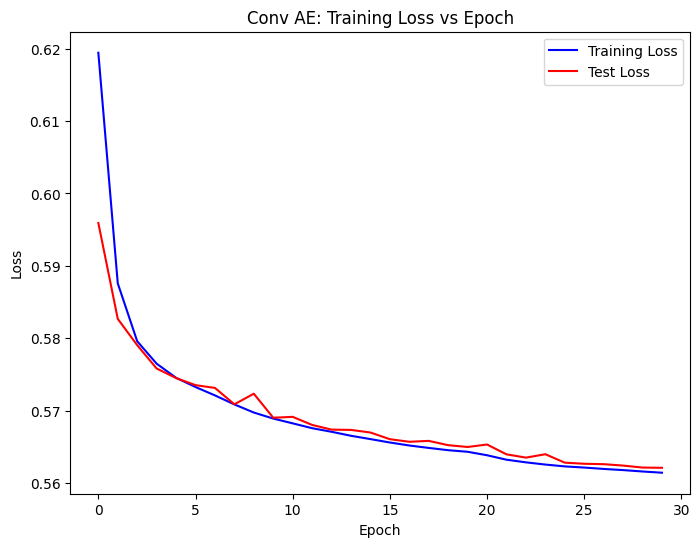

In [10]:
# Plot the loss
plt.figure(figsize=[8,6])
plt.plot(conv_AE_loss_values, '-b', label='Training Loss')
plt.plot(conv_AE_loss_values_test, '-r', label='Test Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Conv AE: Training Loss vs Epoch')
plt.legend(loc='upper right')
plt.show()

### VAE training

In [11]:
loss_values_VAE = []
loss_values_VAE_test = []
# Train the model
for epoch in range(30):
    vae.train()
    total_loss = 0
    for data in train_dataloader:
        img, _ = data  # Assuming labels are not used
        img = img.to(device)
        # print(img.size())
        image_batch_recon, latent_mu, latent_logvar = vae(img)
        loss = vae_loss(image_batch_recon, img, latent_mu, latent_logvar)

        optimizer_vae.zero_grad()
        loss.backward()
        optimizer_vae.step()

        total_loss += loss.item()

    average_loss = total_loss / len(train_dataloader)/batch_size
    loss_values_VAE.append(average_loss)


    vae.eval()
    test_loss_VAE = 0
    # No need to track gradients in test mode
    with torch.no_grad():
        for data in test_dataloader:
            img, label = data
            img = img.to(device)
            output,latent_mu,latent_logvar = vae(img)
            # print(output.max())
            loss = vae_loss(output, img, latent_mu, latent_logvar)
            test_loss_VAE += loss

        # Compute the average test loss
        test_loss_VAE = test_loss_VAE / len(test_dataloader)/10000
        test_loss_VAE = test_loss_VAE.item()
    loss_values_VAE_test.append(test_loss_VAE)
    print(f'Epoch: {epoch+1}, Train Loss: {average_loss:.4f}, Test Loss: {test_loss_VAE:.4f}')

    # save the checpoints
    checkpoint = {
        'epoch': epoch + 1,
        'model_state_dict': vae.state_dict(),
        'optimizer_state_dict': optimizer_vae.state_dict(),
        'loss': test_loss_VAE,
        # any other important info.
    }
    path = "./Checkpoints"
    if not os.path.exists(path): os.mkdir(path)
    torch.save(vae.state_dict(), f'{path}/vae_CIFAR10_checkpoint_{epoch+1}.ckpt')
    # torch.save(checkpoint, f'autoencoder_checkpoint_{epoch+1}.ckpt')

# After training, save the model
path = "./Checkpoints"
if not os.path.exists(path): os.mkdir(path)
torch.save(vae.state_dict(), f'{path}/vae_CIFAR10_final.ckpt')


Epoch: 1, Train Loss: 1968.4068, Test Loss: 1911.0001
Epoch: 2, Train Loss: 1884.2005, Test Loss: 1863.0800
Epoch: 3, Train Loss: 1857.7266, Test Loss: 1845.6367
Epoch: 4, Train Loss: 1846.7689, Test Loss: 1839.3901
Epoch: 5, Train Loss: 1839.7656, Test Loss: 1826.3033
Epoch: 6, Train Loss: 1835.2161, Test Loss: 1823.4290
Epoch: 7, Train Loss: 1832.4476, Test Loss: 1820.8982
Epoch: 8, Train Loss: 1830.5862, Test Loss: 1823.9885
Epoch: 9, Train Loss: 1829.1378, Test Loss: 1817.3271
Epoch: 10, Train Loss: 1828.0093, Test Loss: 1815.4437
Epoch: 11, Train Loss: 1827.0270, Test Loss: 1814.2351
Epoch: 12, Train Loss: 1826.2702, Test Loss: 1814.1748
Epoch: 13, Train Loss: 1825.1560, Test Loss: 1812.6831
Epoch: 14, Train Loss: 1824.2556, Test Loss: 1811.5327
Epoch: 15, Train Loss: 1823.6148, Test Loss: 1810.6394
Epoch: 16, Train Loss: 1823.0623, Test Loss: 1811.6837
Epoch: 17, Train Loss: 1822.5364, Test Loss: 1810.9073
Epoch: 18, Train Loss: 1822.1483, Test Loss: 1809.8612
Epoch: 19, Train Lo

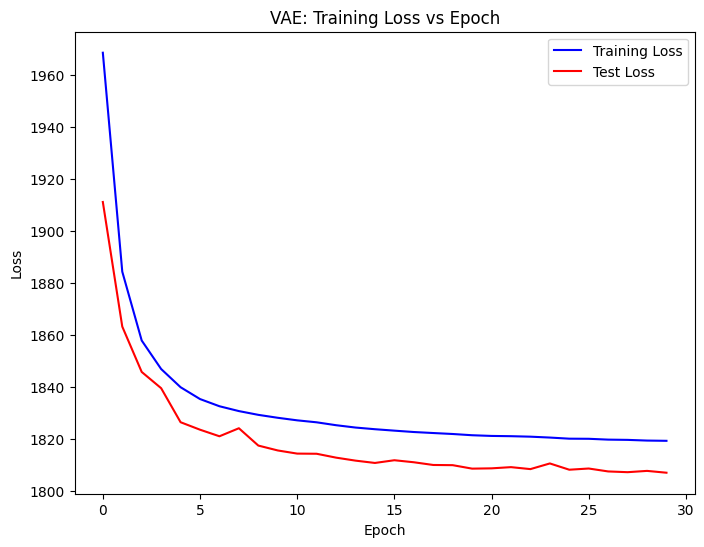

In [12]:
# Plot the loss
plt.figure(figsize=[8,6])
plt.plot(loss_values_VAE, '-b', label='Training Loss')
plt.plot(loss_values_VAE_test, '-r', label='Test Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('VAE: Training Loss vs Epoch')
plt.legend(loc='upper right')
plt.show()

## Test set evaluation

### Conv AE evaluation

In [13]:
# load model
conv_AE.load_state_dict(torch.load('./Checkpoints/autoencoder_CIFAR10_final.ckpt'))
# # Switch the model to evaluation mode
conv_AE.eval()

# Initialize the test loss
test_loss_conv_ae = 0

# No need to track gradients in test mode
with torch.no_grad():
    for data in test_dataloader:
        img, label = data
        img = img.to(device)
        output = conv_AE(img)
        loss = criterion_conv_AE(output, img)
        test_loss_conv_ae += loss.item()

    # Compute the average test loss
    test_loss_conv_ae = test_loss_conv_ae / len(test_dataloader)
    print(f'Conv AE Test Loss: {test_loss_conv_ae:.4f}')


Conv AE Test Loss: 0.5621


### VAE evaluation

In [14]:

vae.load_state_dict(torch.load('./Checkpoints/vae_CIFAR10_final.ckpt'))
# # Switch the model to evaluation mode
vae.eval()
criterion_bce = nn.BCELoss()
# Initialize the test loss
test_loss_VAE_BCE = 0
test_loss_VAE = 0
# No need to track gradients in test mode
with torch.no_grad():
    for data in test_dataloader:
        img, label = data
        img = img.to(device)
        output,latent_mu,latent_logvar = vae(img)
        # print(output.max())
        loss = criterion_bce(output, img)
        loss2 = vae_loss(output, img, latent_mu, latent_logvar)
        test_loss_VAE += loss2
        test_loss_VAE_BCE += loss.item()

    # Compute the average test loss
    test_loss_VAE_BCE = test_loss_VAE_BCE / len(test_dataloader)
    test_loss_VAE = test_loss_VAE / len(test_dataloader)/10000
    print(f'VAE Test Loss (BCE): {test_loss_VAE_BCE:.4f}')
    print(f'VAE Test Loss : {test_loss_VAE:.4f}')

VAE Test Loss (BCE): 0.5741
VAE Test Loss : 1806.8822


## Latent space visualization

### Function

In [15]:
# functions to plot the latent space of autoencoders
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from sklearn.cluster import KMeans
# from openTSNE import TSNE
import umap

def plot_latent_space(fig_name:str="test", show=False,model:nn.Module=conv_AE,method:str="PCA",isvae:bool=False):
    
    model.eval() # Switch the model to evaluation mode
    points = [] # 2D 
    label_idcs = [] # labels of points
    
    path = "./ScatterPlots"
    if not os.path.exists(path): os.mkdir(path)
    

    for i, data in enumerate(test_dataloader):
        img, label = [d.to(device) for d in data]
        if isvae == True:   # preprocessing for vae, since vae's encoder returns two vectors: means, and variances 
            proj1, proj2 = model.encoder(img)
            proj1=proj1.detach().cpu().numpy()
            proj2=proj2.detach().cpu().numpy()
            proj = np.hstack((proj1,proj2))
        else:   # if it is not vae simply derive the output of its encoder
            proj = model.encoder(img)
            proj = proj.detach().cpu().numpy()
        
        # Apply KMeans before using high dimensional data visualization methods
        kmeans=KMeans(n_clusters=10, random_state=0, n_init="auto").fit(proj)
        labels_KMeans = kmeans.labels_
        

        # high dimensional data visualization methods: PCA, t-SNE, UMAP
        if method =="PCA":
            pca = PCA(n_components=2)
            temp = pca.fit_transform(proj)
            points.extend(temp)

        if method == "UMAP":
            reducer = umap.UMAP(random_state=42)
            embedding = reducer.fit_transform(proj)
            points.extend(embedding)
        
        if method == "TSNE":
            temp=TSNE(n_components=2).fit_transform(proj)
            points.extend(temp)

        if method == "NONE":
            points.extend(proj)
        
        label_idcs.extend(label.detach().cpu().numpy())
        del img, label # delete img and label
    
    label_idcs = np.array(label_idcs)
    points = np.array(points)
    
    x=points[:, 0]
    y=points[:, 1]

    # Latent space visualization (2D)
    plt.figure(1)
    fig, ax = plt.subplots(figsize=(10, 10) if not show else (8, 8))
    for i in range(10):
        scatter = ax.scatter(x[np.where(label_idcs==i)[0]], y[np.where(label_idcs==i)[0]], s=20.0, 
                 label=i, alpha=0.7, zorder=2)
    ax.set_title("Latent space visualization using "+method)
    ax.legend()
    ax.spines["right"].set_visible(False)
    ax.spines["top"].set_visible(False)
    
    if show: 
        ax.grid(True, color="lightgray", alpha=1.0, zorder=0)
        plt.show()
    else: 
        # Do not show but only save the plot in training
        plt.savefig(f"{path}/MNIST_{fig_name}.png", bbox_inches="tight")
        plt.close() # don't forget to close the plot, or it is always in memory
        model.train()


    # Latent space visualization with labels obtained by KMeans
    plt.figure(2)
    fig, ax = plt.subplots(figsize=(10, 10) if not show else (8, 8))
    for i in range(10):
        scatter = ax.scatter(x[np.where(labels_KMeans==i)[0]], y[np.where(labels_KMeans==i)[0]], s=20.0, 
                 label=i, alpha=0.7, zorder=2)
    ax.set_title("KMeans_clustering")
    # ax.legend()
    ax.spines["right"].set_visible(False)
    ax.spines["top"].set_visible(False)
    
    if show: 
        ax.grid(True, color="lightgray", alpha=1.0, zorder=0)
        plt.show()
    else: 
        # Do not show but only save the plot in training
        plt.savefig(f"{path}/MNIST_{fig_name}_KMeans_clustering.png", bbox_inches="tight")
        plt.close() # don't forget to close the plot, or it is always in memory
        model.train()

### Conv AE Latent space

<Figure size 640x480 with 0 Axes>

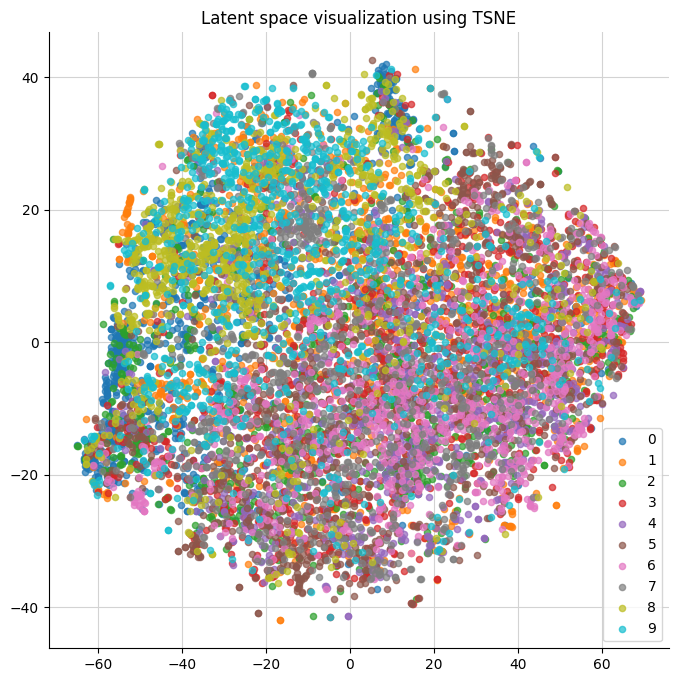

<Figure size 640x480 with 0 Axes>

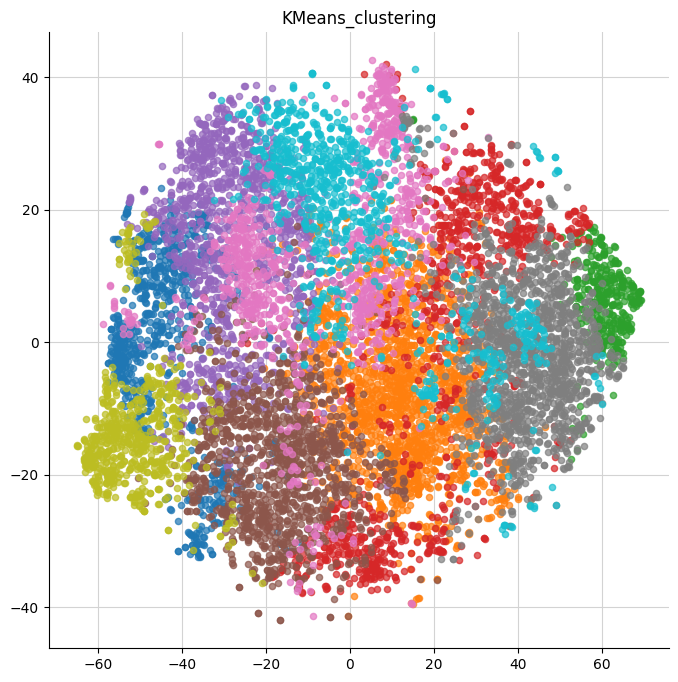

In [16]:
plot_latent_space("Conv AE", show=True,model=conv_AE,method="TSNE",isvae=False)

<Figure size 640x480 with 0 Axes>

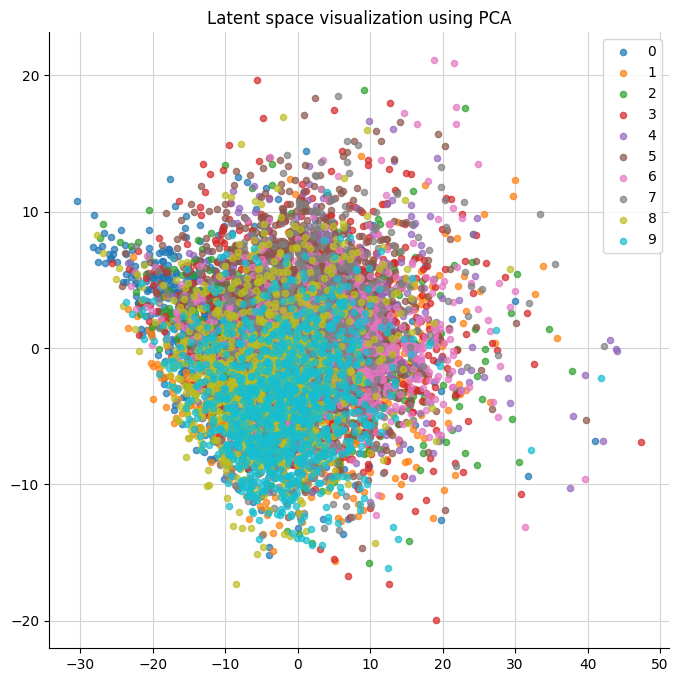

<Figure size 640x480 with 0 Axes>

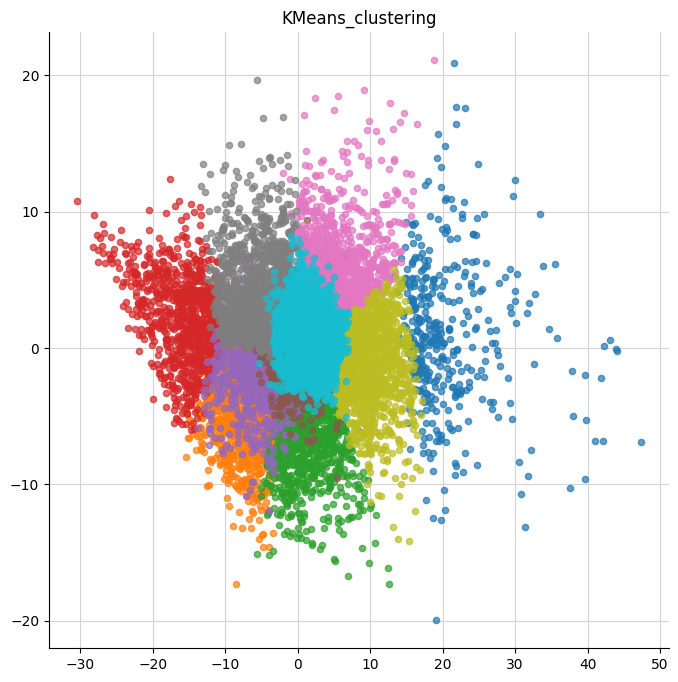

In [17]:
plot_latent_space("Conv AE", show=True,model=conv_AE,method="PCA",isvae=False)

c:\Users\hsingyuan\Desktop\python project\.venv\lib\site-packages\umap\umap_.py:1943: UserWarning: n_jobs value -1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")


<Figure size 640x480 with 0 Axes>

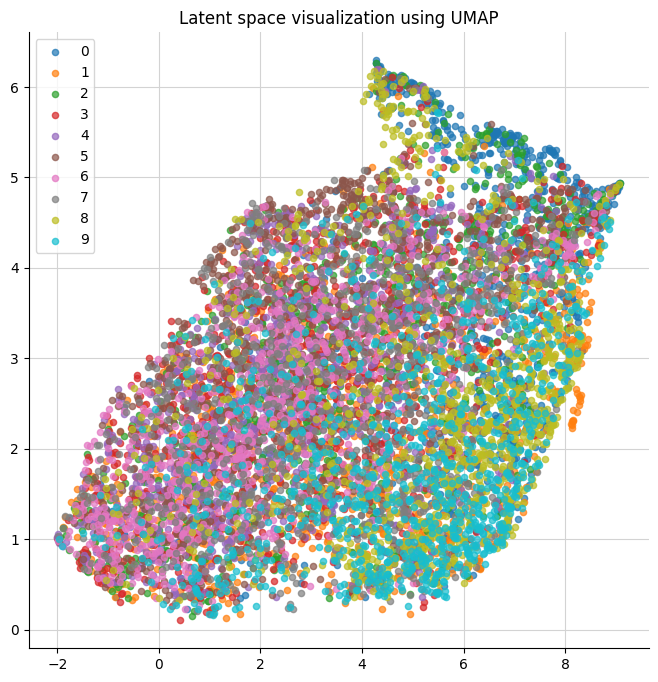

<Figure size 640x480 with 0 Axes>

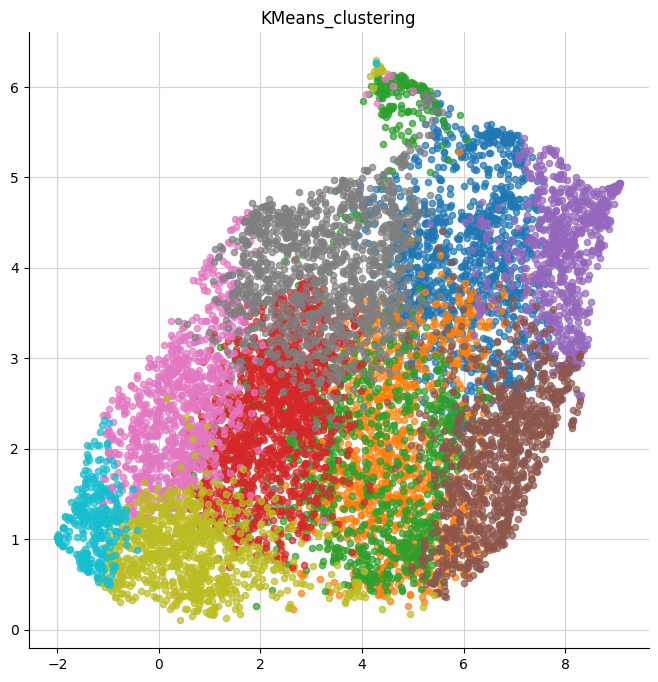

In [18]:
plot_latent_space("Conv AE", show=True,model=conv_AE,method="UMAP",isvae=False)

### VAE latent space

<Figure size 640x480 with 0 Axes>

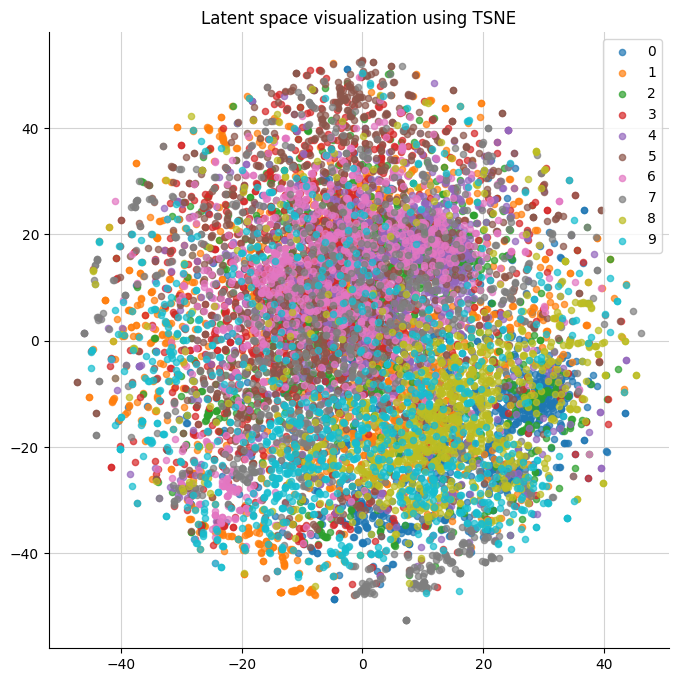

<Figure size 640x480 with 0 Axes>

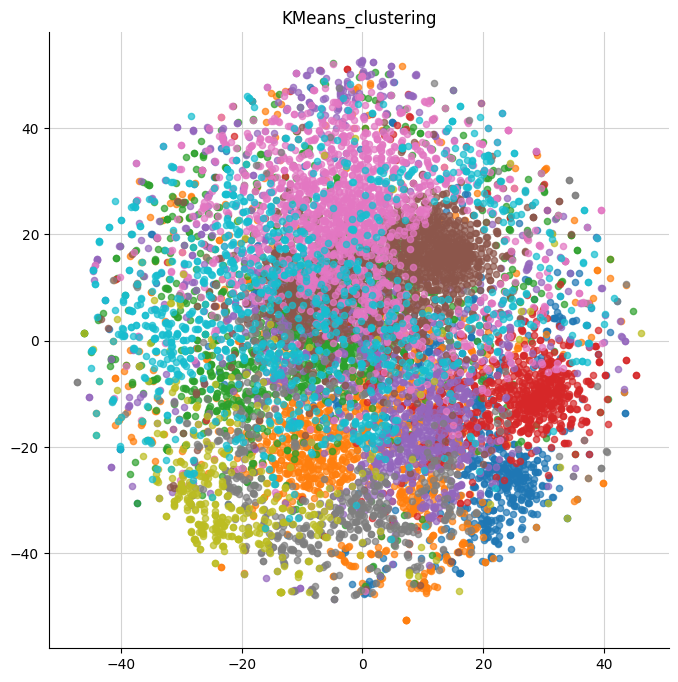

In [19]:
plot_latent_space("VAE", show=True,model=vae,method="TSNE",isvae=True)

<Figure size 640x480 with 0 Axes>

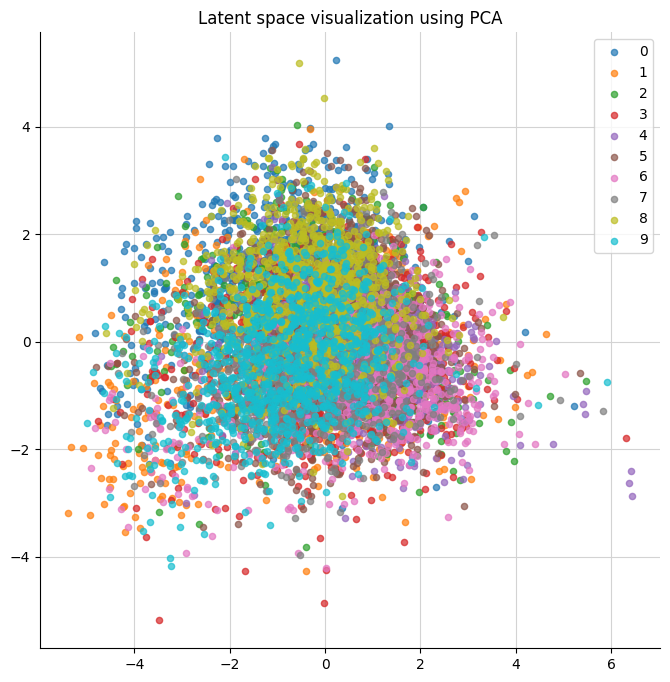

<Figure size 640x480 with 0 Axes>

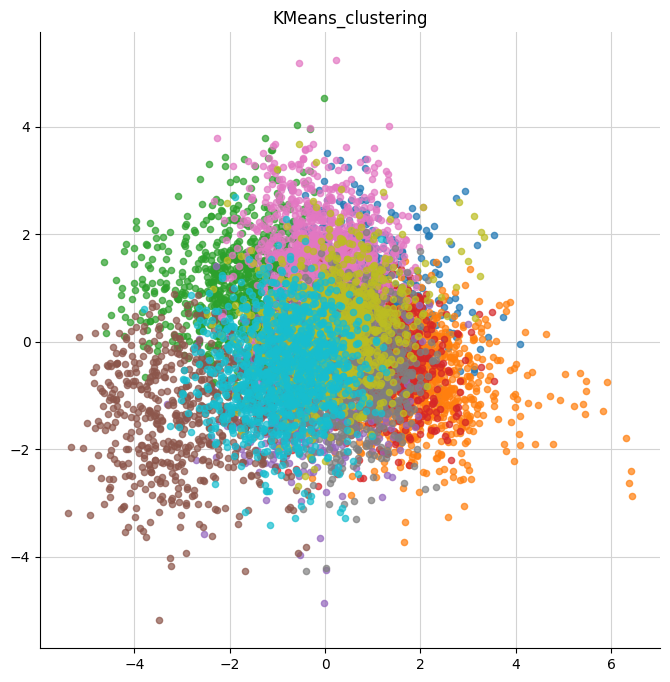

In [20]:
plot_latent_space("VAE", show=True,model=vae,method="PCA",isvae=True)

c:\Users\hsingyuan\Desktop\python project\.venv\lib\site-packages\umap\umap_.py:1943: UserWarning: n_jobs value -1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")


<Figure size 640x480 with 0 Axes>

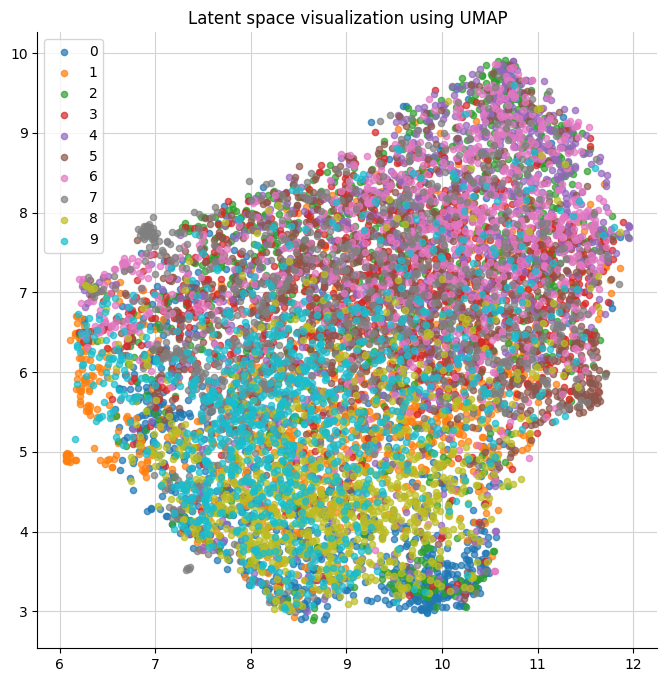

<Figure size 640x480 with 0 Axes>

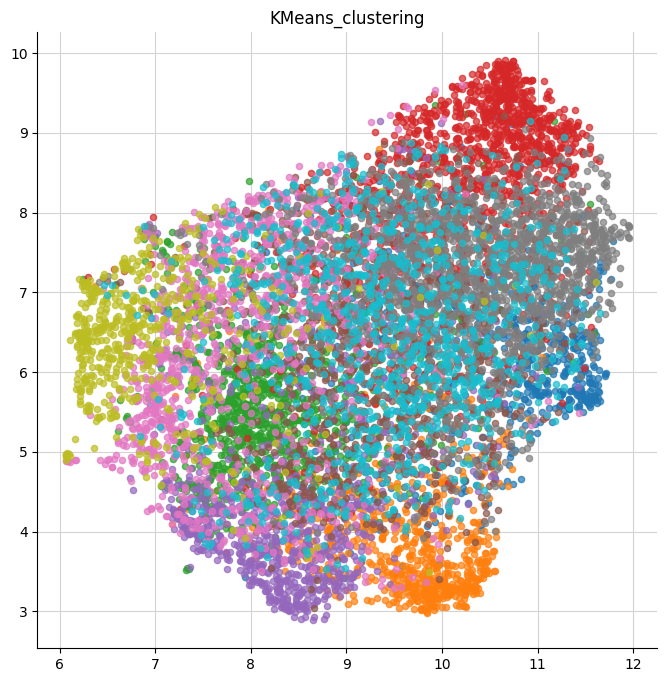

In [21]:
plot_latent_space("VAE", show=True,model=vae,method="UMAP",isvae=True)

## Original images vs Reconstructed images

### Conv AE images

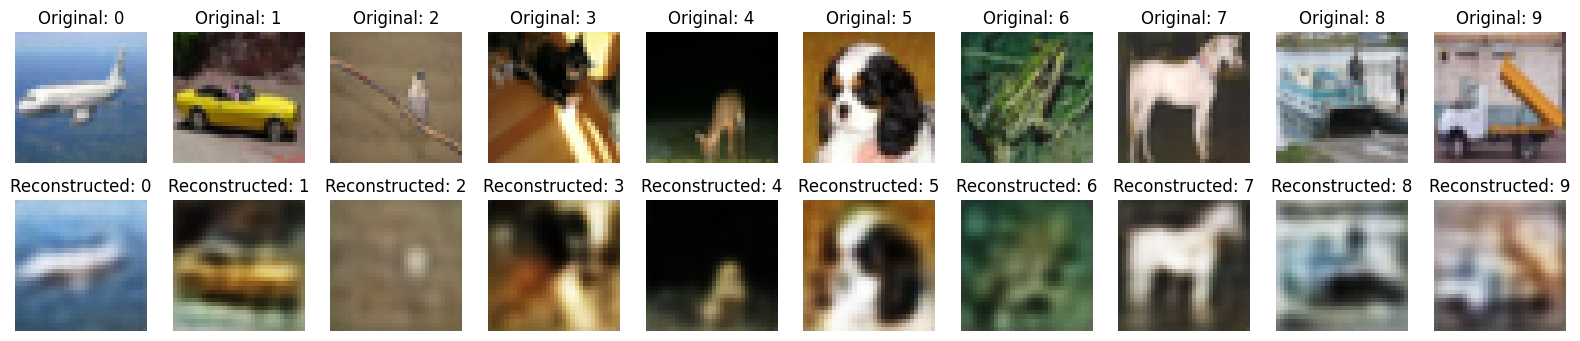

In [22]:
reconstructed_images_conv_AE = {}

for label, img in sorted_categories.items():
    conv_AE.eval()
    img = torch.from_numpy(img)
    img = img.permute(2, 0, 1)
    img = img.to(device)
    
    img_reconstructed = conv_AE(img)
    img_reconstructed = img_reconstructed.view(3,32,32)
    img_reconstructed = img_reconstructed.detach().cpu().numpy()
    img_reconstructed = np.transpose(img_reconstructed, (1, 2, 0))
    reconstructed_images_conv_AE[label] = img_reconstructed

fig, axs = plt.subplots(2, 10, figsize=(20, 4))
for label, img in sorted_categories.items():
    axs[0, label].imshow(sorted_categories[label])
    axs[0, label].set_title(f'Original: {label}')
    axs[0, label].axis('off')
    axs[1, label].imshow(reconstructed_images_conv_AE[label])
    axs[1, label].set_title(f'Reconstructed: {label}')
    axs[1, label].axis('off')

plt.show()


### VAE images

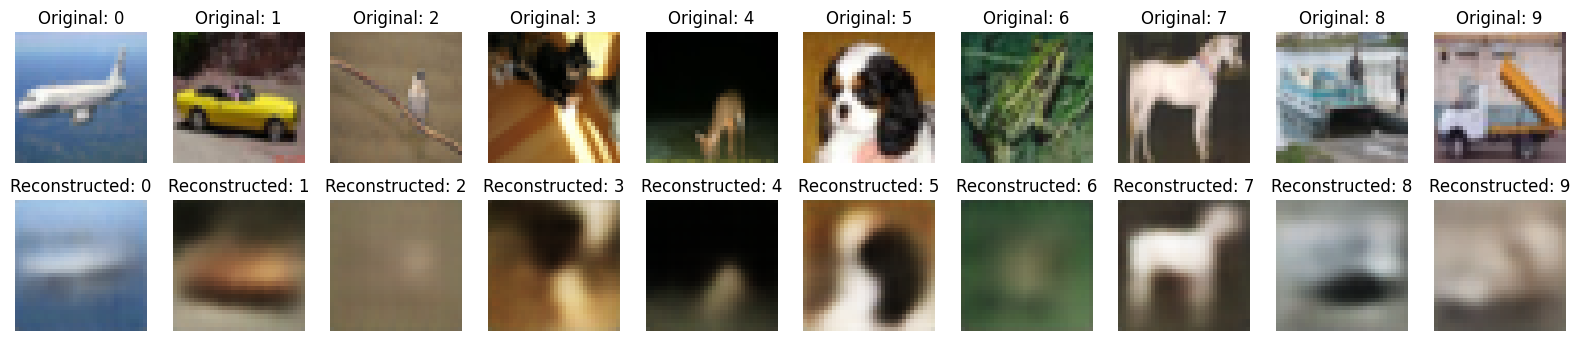

In [23]:
reconstructed_images_vae = {}

for label, img in sorted_categories.items():
    conv_AE.eval()
    img = torch.from_numpy(img)
    img = img.permute(2, 0, 1)
    img = img.to(device)
    
    img_reconstructed,_,_ = vae(img)
    img_reconstructed = img_reconstructed.view(3,32,32)
    img_reconstructed = img_reconstructed.detach().cpu().numpy()
    img_reconstructed = np.transpose(img_reconstructed, (1, 2, 0))
    reconstructed_images_vae[label] = img_reconstructed

fig, axs = plt.subplots(2, 10, figsize=(20, 4))
for label, img in sorted_categories.items():
    axs[0, label].imshow(sorted_categories[label])
    axs[0, label].set_title(f'Original: {label}')
    axs[0, label].axis('off')
    axs[1, label].imshow(reconstructed_images_vae[label])
    axs[1, label].set_title(f'Reconstructed: {label}')
    axs[1, label].axis('off')

plt.show()

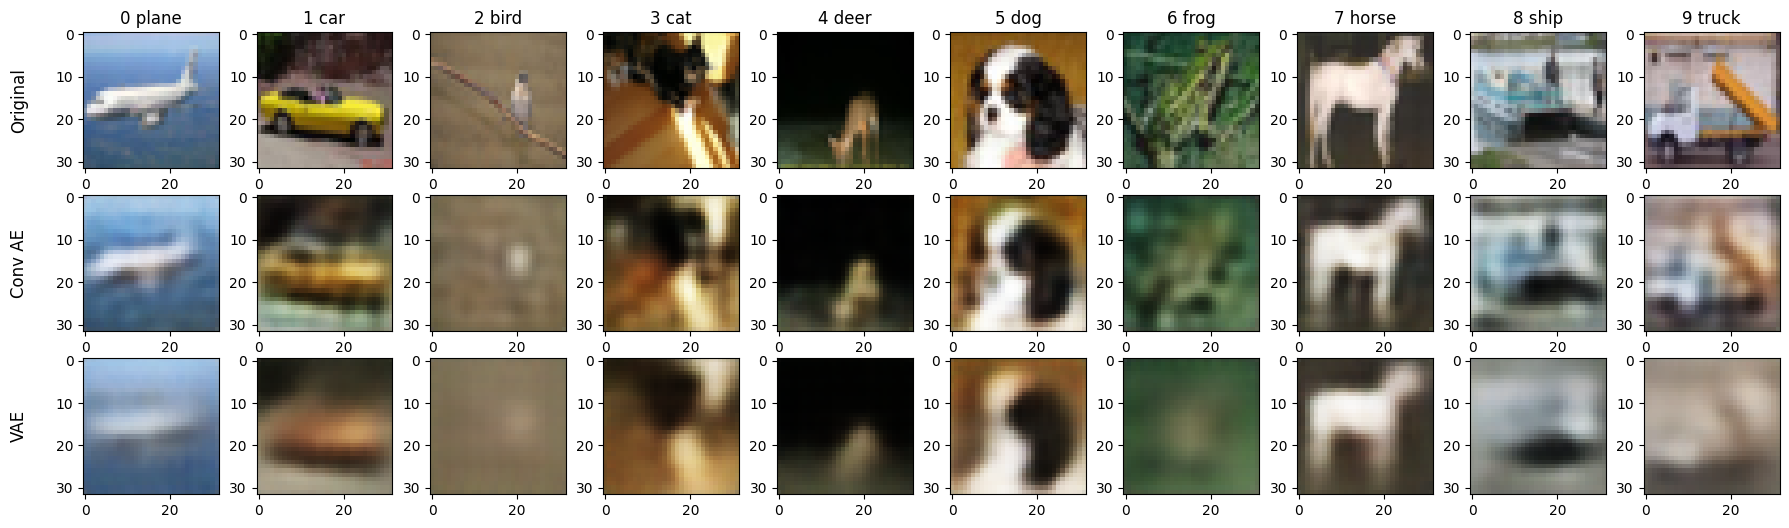

In [24]:
fig, axs = plt.subplots(3, 10, figsize=(22, 6))

# Set titles for each row
row_titles = ['Original', 'Conv AE', 'VAE']
for i in range(3):
    axs[i, 0].set_ylabel(row_titles[i], rotation=90, size='large', labelpad=20)

# Set titles for each column
CIFAR10_labels = ['plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']
for i in range(10):
    axs[0, i].set_title(f'{i} '+CIFAR10_labels[i])



for label, img in sorted_categories.items():
    axs[0, label].imshow(sorted_categories[label])
    # axs[0, label].axis('off')
    axs[1, label].imshow(reconstructed_images_conv_AE[label])
    # axs[1, label].axis('off')
    axs[2, label].imshow(reconstructed_images_vae[label])
    # axs[2, label].axis('off')

# plt.tight_layout()
plt.show()